# Main Portfolio (Equity/Bonds Strategies)

In [ ]:
!pip3 install -r requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
# import ffn
import bt
from datetime import timedelta

%matplotlib inline

In [4]:
tickers = [
    'IWDA.AS',  # MSCI World Equity
    'IEAC.L'    # Bonds
    #'IBGS.AS'  # Cash
    ]
df = yf.download(tickers, period='10y')['Adj Close']
df

[*********************100%***********************]  2 of 2 completed


Ticker,IEAC.L,IWDA.AS
Date,,
2014-11-04 00:00:00+00:00,109.754715,32.540001
2014-11-05 00:00:00+00:00,109.754715,32.959999
2014-11-06 00:00:00+00:00,109.814529,33.165001
2014-11-07 00:00:00+00:00,109.882843,33.215000
2014-11-10 00:00:00+00:00,109.891396,33.334999
...,...,...
2024-10-29 00:00:00+00:00,120.430000,99.769997
2024-10-30 00:00:00+00:00,120.110001,99.290001
2024-10-31 00:00:00+00:00,119.970001,97.550003


In [5]:
# Fill missing values by interpolating with method that takes average of previous and next values
data = df.interpolate(method='linear', limit_direction='both')
data

Ticker,IEAC.L,IWDA.AS
Date,,
2014-11-04 00:00:00+00:00,109.754715,32.540001
2014-11-05 00:00:00+00:00,109.754715,32.959999
2014-11-06 00:00:00+00:00,109.814529,33.165001
2014-11-07 00:00:00+00:00,109.882843,33.215000
2014-11-10 00:00:00+00:00,109.891396,33.334999
...,...,...
2024-10-29 00:00:00+00:00,120.430000,99.769997
2024-10-30 00:00:00+00:00,120.110001,99.290001
2024-10-31 00:00:00+00:00,119.970001,97.550003


<Axes: xlabel='Date'>

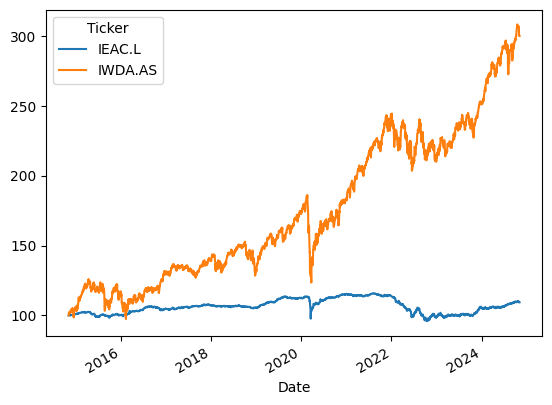

In [6]:
data.rebase().plot()

## 70/30 Portfolio

In [6]:
# create a strategy
p7030w_strategy = bt.Strategy('p7030w', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighSpecified(**{
        'IWDA.AS': 0.7,   # MSCI World Equity
        'IEAC.L': 0.3,   # Bonds
        #'IBGS.AS': 0.05   # Cash
    }),
    bt.algos.Rebalance(),
])
# create a backtest
p7030w_backtest = bt.Backtest(p7030w_strategy, data)

## Equally weighted

In [7]:
# create a strategy
EW_strategy = bt.Strategy('EW', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
# create a backtest
EW_backtest = bt.Backtest(EW_strategy, data)

## MeanVar

In [8]:
# create a strategy
MeanVar_strategy = bt.Strategy('MeanVar', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=365)),
    bt.algos.SelectAll(),
    bt.algos.WeighMeanVar(lookback=pd.DateOffset(years=1),),
    bt.algos.Rebalance()
])

# create a backtest
MeanVar_backtest = bt.Backtest(MeanVar_strategy, data)

## ERC

In [9]:
# create a strategy
ERC_strategy = bt.Strategy('ERC', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=365)),
    bt.algos.SelectAll(),
    bt.algos.WeighERC(lookback=pd.DateOffset(years=1),),
    bt.algos.Rebalance()
])

# create a backtest
ERC_backtest = bt.Backtest(ERC_strategy, data)

## Inverse Volatility

In [10]:
# create a strategy
InvVol_strategy = bt.Strategy('InvVol', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighInvVol(),
    bt.algos.Rebalance()
])

# create a backtest
InvVol_backtest = bt.Backtest(InvVol_strategy, data)

## Momentum

In [11]:
# create a strategy
Momentum_strategy = bt.Strategy('Momentum', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=92)),
    bt.algos.SelectAll(),
    bt.algos.SelectMomentum(n=4,lookback=pd.DateOffset(months=3)),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# create a backtest
Momentum_backtest = bt.Backtest(Momentum_strategy, data)

## Efficient Frontier

In [12]:
from pypfopt import EfficientFrontier, expected_returns, risk_models

class EF_Weights(bt.Algo):
    """
    TODO
    """

    def __init__(self, method: str = 'max_sharpe'):
        self.method = method
        super(EF_Weights, self).__init__()

    def __call__(self, target):
        df=target.universe.dropna()
        # Calculate expected returns and sample covariance
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)
        #S = risk_models.exp_cov(df)

        # Optimize for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S)
        # ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
        ef.add_constraint(lambda w: w >= 0.1)

        getattr(ef, self.method)()
        weights = ef.clean_weights()
        # print(weights)

        target.temp['weights'] = weights
        return True

### Max Sharpe Ratio

In [13]:
# create a strategy
MSR_strategy = bt.Strategy('MSR', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=3)),
    bt.algos.SelectAll(),
    EF_Weights('max_sharpe'),
    bt.algos.Rebalance()
])

# create a backtest
MSR_backtest = bt.Backtest(MSR_strategy, data)

### Global Minimum Volatility

In [14]:
# create a strategy
GMV_strategy = bt.Strategy('GMV', [
    bt.algos.RunMonthly(),
    bt.algos.RunAfterDate(data.index.min() + timedelta(days=3)),
    bt.algos.SelectAll(),
    EF_Weights('min_volatility'),
    bt.algos.Rebalance()
])

# create a backtest
GMV_backtest = bt.Backtest(GMV_strategy, data)

## SMA

<Axes: xlabel='Date'>

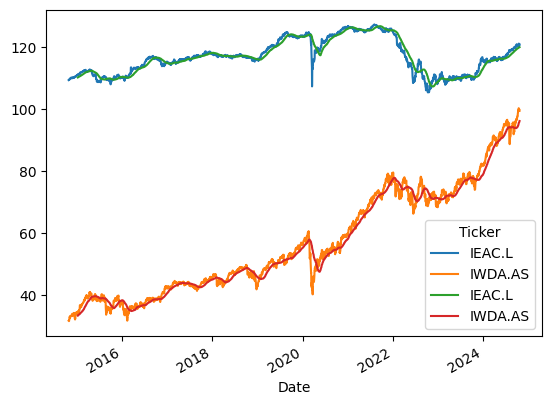

In [15]:
# simple moving average: 50 days
sma = data.rolling(window=50).mean()
bt.merge(data, sma).plot()

In [16]:
# create a strategy
SMA_strategy = bt.Strategy('SMA', [
    bt.algos.SelectWhere(data > sma),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()]
    )

# create a backtest
SMA_backtest = bt.Backtest(SMA_strategy, data)

## RSI

## MACD

## Compute and Plot

In [17]:
report = bt.run(
    MSR_backtest,
    GMV_backtest,
    SMA_backtest,
    p7030w_backtest,
    EW_backtest,
    MeanVar_backtest,
    ERC_backtest,
    InvVol_backtest,
    Momentum_backtest
)

 78%|███████▊  | 7/9 [00:08<00:01,  1.10it/s]c:\Users\jlche\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\jlche\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future

<Axes: title={'center': 'Equity Progression'}>

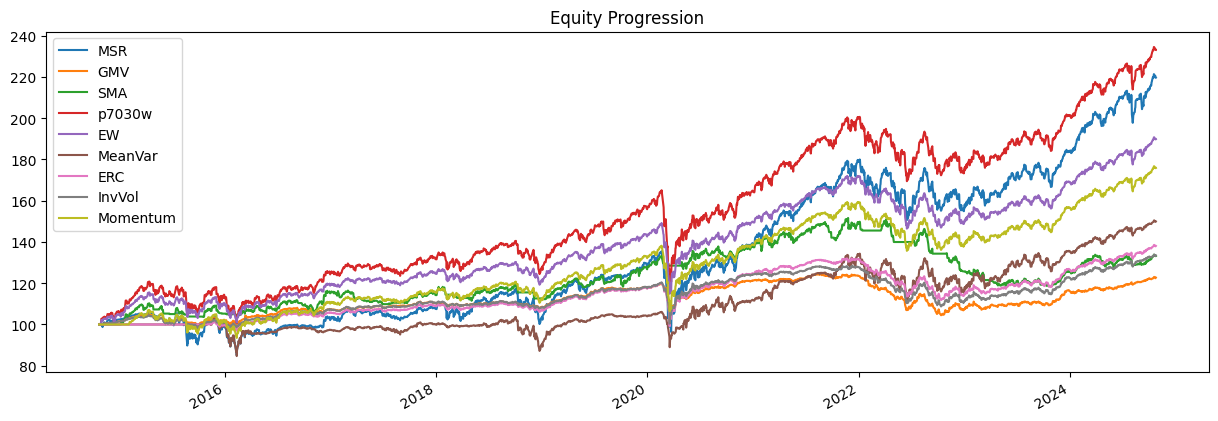

In [18]:
report.plot()

In [19]:
report.display()

Stat                 MSR         GMV         SMA         p7030w      EW          MeanVar     ERC         InvVol      Momentum
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2014-10-23  2014-10-23  2014-10-23  2014-10-23  2014-10-23  2014-10-23  2014-10-23  2014-10-23  2014-10-23
End                  2024-10-24  2024-10-24  2024-10-24  2024-10-24  2024-10-24  2024-10-24  2024-10-24  2024-10-24  2024-10-24
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         119.68%     22.74%      33.21%      133.11%     89.84%      49.97%      38.09%      33.48%      75.87%
Daily Sharpe         0.64        0.45        0.43        0.78        0.76        0.43        0.62        0.57        0.68
Daily Sortino        0.97        0.67        0.64        1.20        1.16        0.64        0.92        0.85        1.0

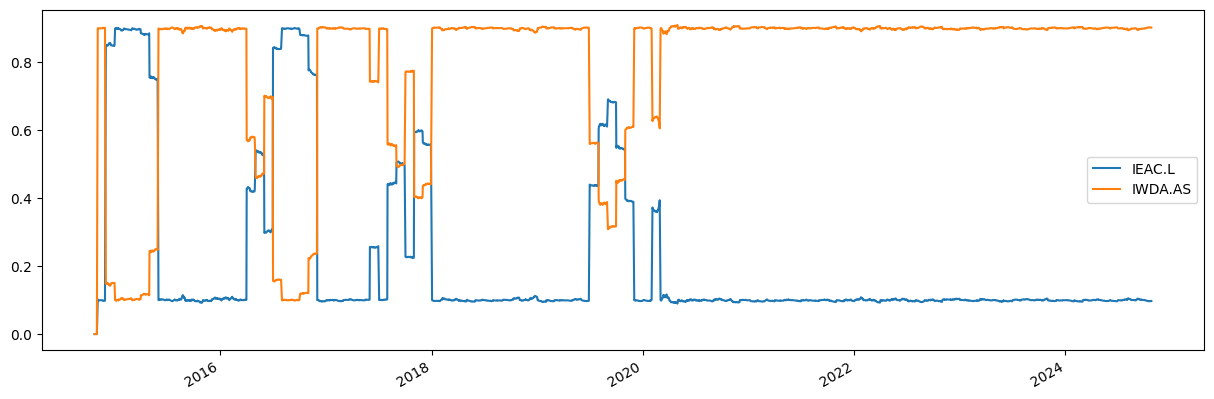

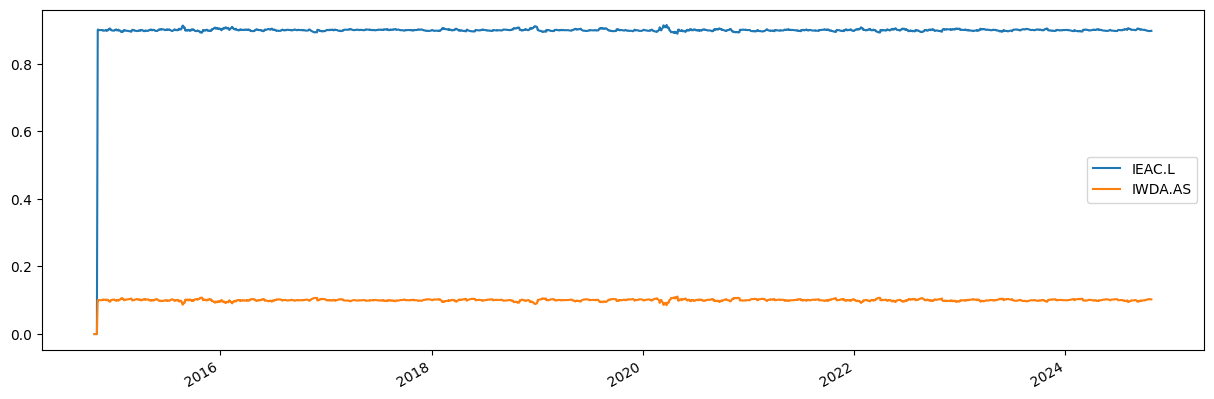

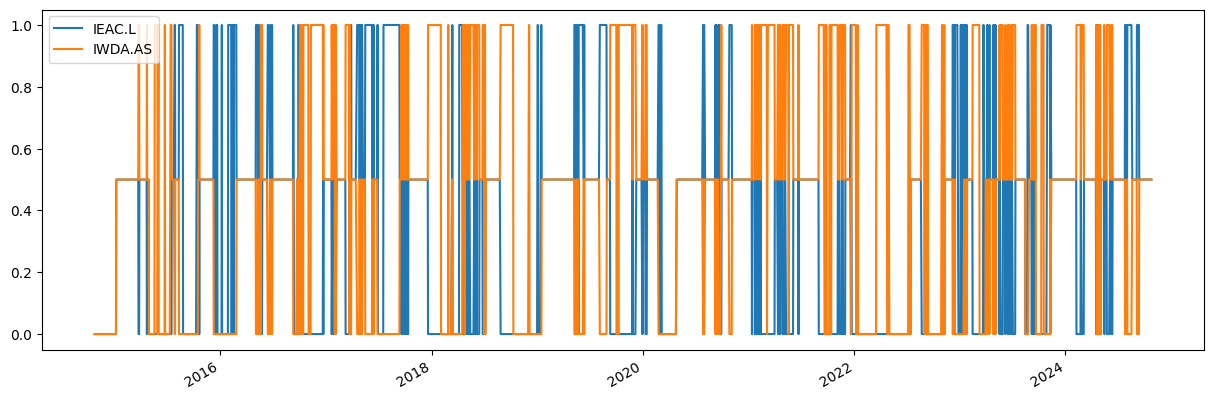

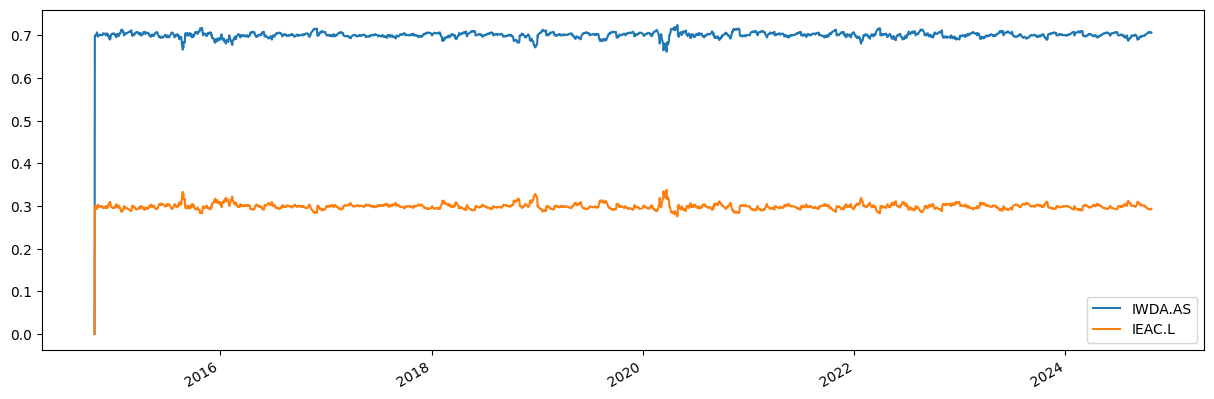

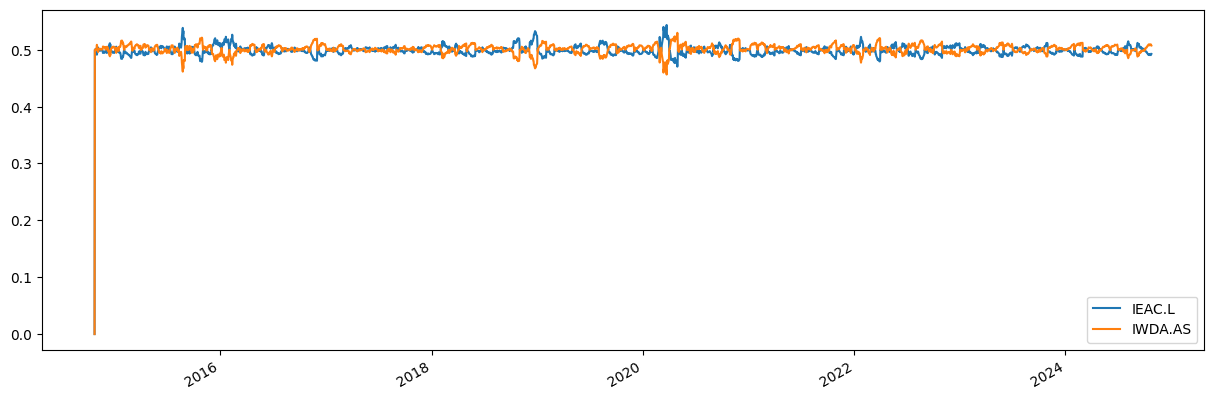

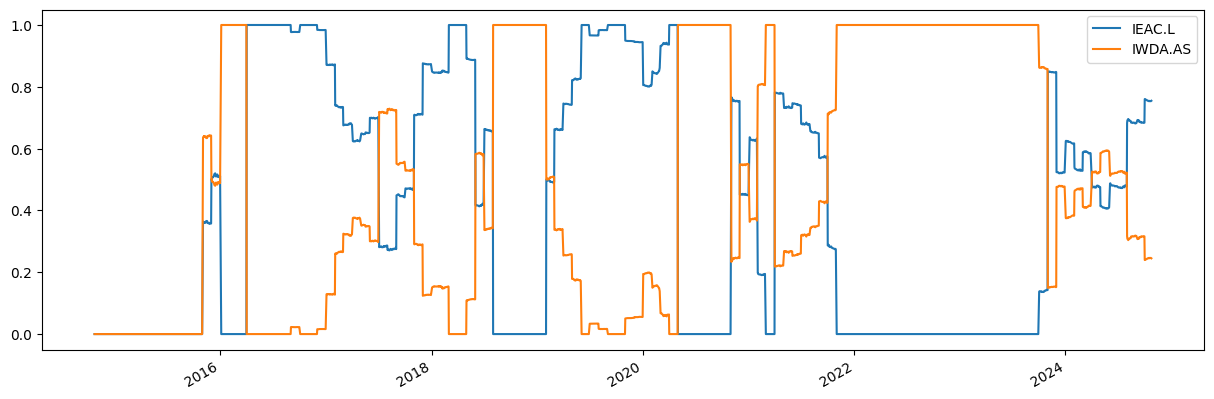

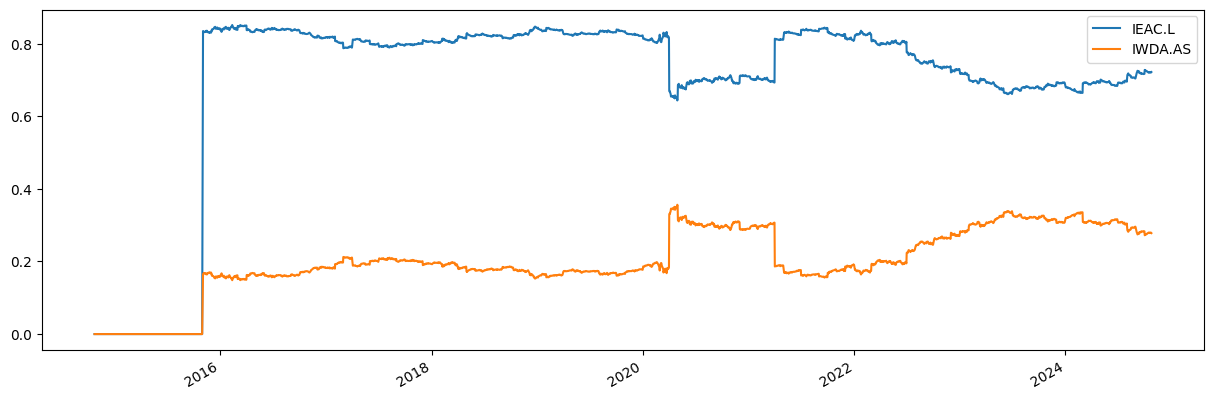

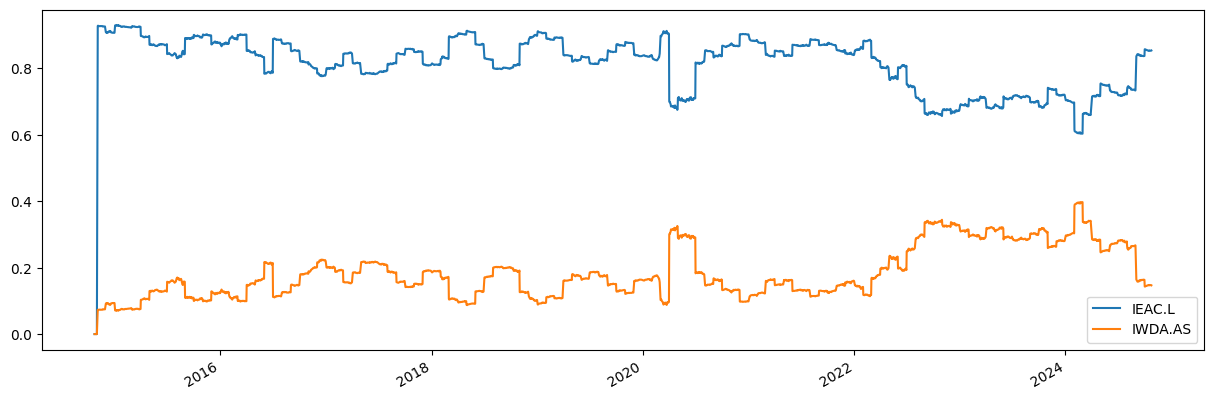

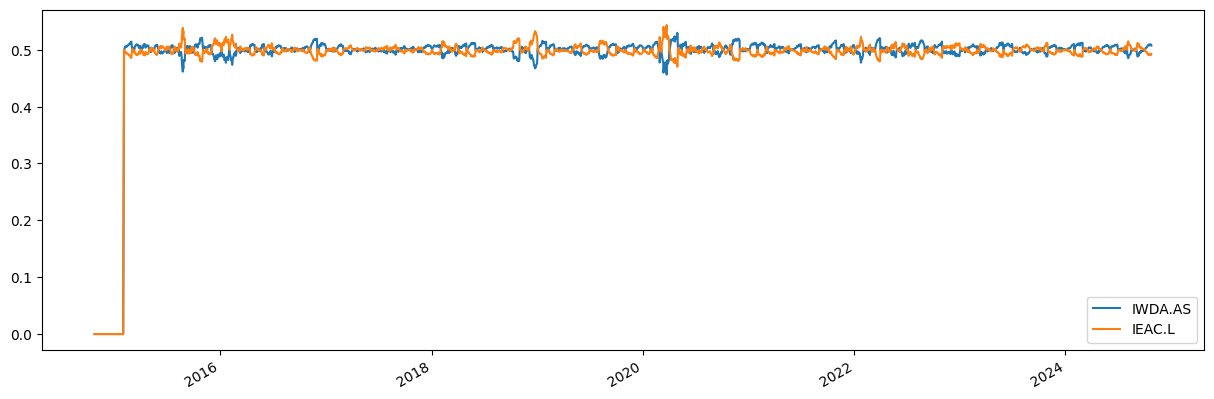

In [20]:
for i in range(len(report.keys())):
    report.plot_security_weights(i)